<a href="https://www.kaggle.com/code/klyushnik/episode-9?scriptVersionId=168290862" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e9/sample_submission.csv
/kaggle/input/playground-series-s3e9/train.csv
/kaggle/input/playground-series-s3e9/test.csv
/kaggle/input/predict-concrete-strength/ConcreteStrengthData.csv


# # I started practicing for the first 4 months

**From last posts https://www.kaggle.com/code/klyushnik/episode-9-fast-start, I know the top 3 regressors: CatBoostRegressor, Xgboost, Lightgbm**

**I looked at the example, this person:  https://www.kaggle.com/tetsutani  THANK YOU SO MUSH!!!!**

# Import libraries

In [2]:
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import warnings
warnings.filterwarnings('ignore')
from IPython.display import Image
%matplotlib inline

import random
import os
from copy import deepcopy
from functools import partial
from itertools import combinations

# Import sklearn classes for model selection, cross validation, and performance evaluation
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score, accuracy_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import seaborn as sns
from category_encoders import OneHotEncoder, OrdinalEncoder, CountEncoder
from sklearn.model_selection import GridSearchCV

import optuna

import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoost, CatBoostRegressor, CatBoostClassifier
from catboost import Pool

# Suppress warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Load data

In [3]:
test = pd.read_csv('/kaggle/input/playground-series-s3e9/test.csv')
train = pd.read_csv('/kaggle/input/playground-series-s3e9/train.csv')
org = pd.read_csv('/kaggle/input/predict-concrete-strength/ConcreteStrengthData.csv')

**Connect data**

In [4]:
train = pd.concat([train, org], ignore_index=True)

**Removing excess**

In [5]:
train = train.drop( train.columns[-1], axis=1)

# Let's show the Links

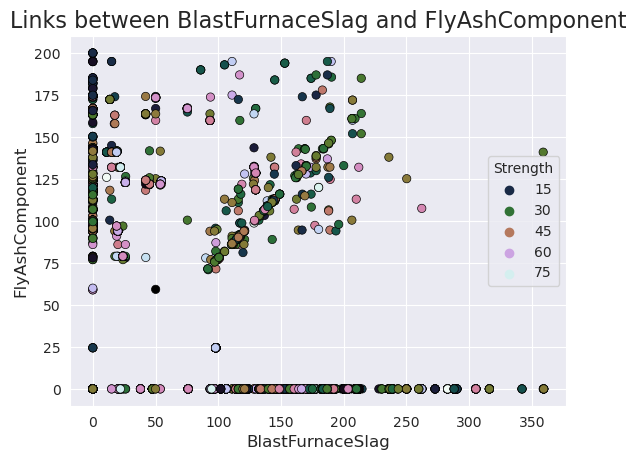

In [6]:
sns.set_style('darkgrid')
plt.title('Links between BlastFurnaceSlag and FlyAshComponent',size=16)
plt.xlabel('BlastFurnaceSlag',size=12)
plt.ylabel('FlyAshComponent',size=12)
sns.scatterplot(x='BlastFurnaceSlag', y='FlyAshComponent', data=train,hue='Strength', edgecolor='black', palette='cubehelix')
plt.show()

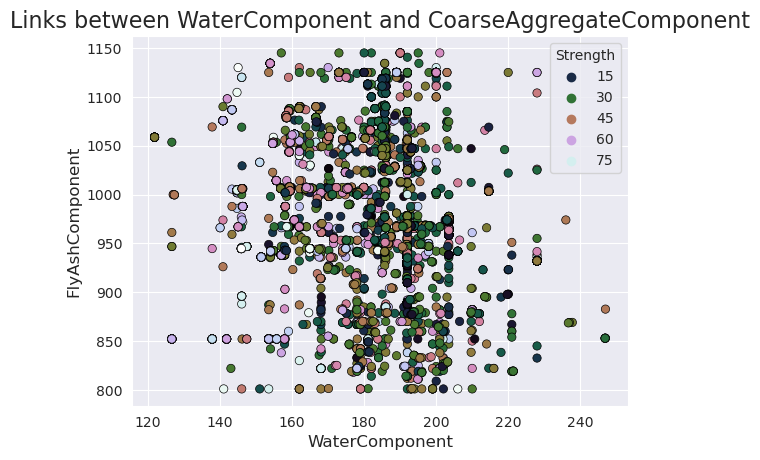

In [7]:
sns.set_style('darkgrid')
plt.title('Links between WaterComponent and CoarseAggregateComponent',size=16)
plt.xlabel('WaterComponent',size=12)
plt.ylabel('FlyAshComponent',size=12)
sns.scatterplot(x='WaterComponent', y='CoarseAggregateComponent', data=train,hue='Strength', edgecolor='black', palette='cubehelix')
plt.show()

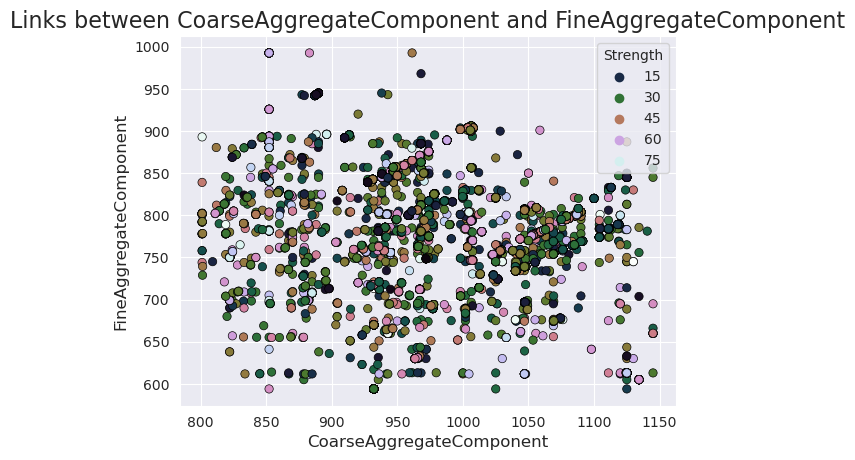

In [8]:
sns.set_style('darkgrid')
plt.title('Links between CoarseAggregateComponent and FineAggregateComponent',size=16)
plt.xlabel('CoarseAggregateComponent',size=12)
plt.ylabel('FineAggregateComponent',size=12)
sns.scatterplot(x='CoarseAggregateComponent', y='FineAggregateComponent', data=train,hue='Strength', edgecolor='black', palette='cubehelix')
plt.show()

**Plot train data**

<Figure size 800x640 with 0 Axes>

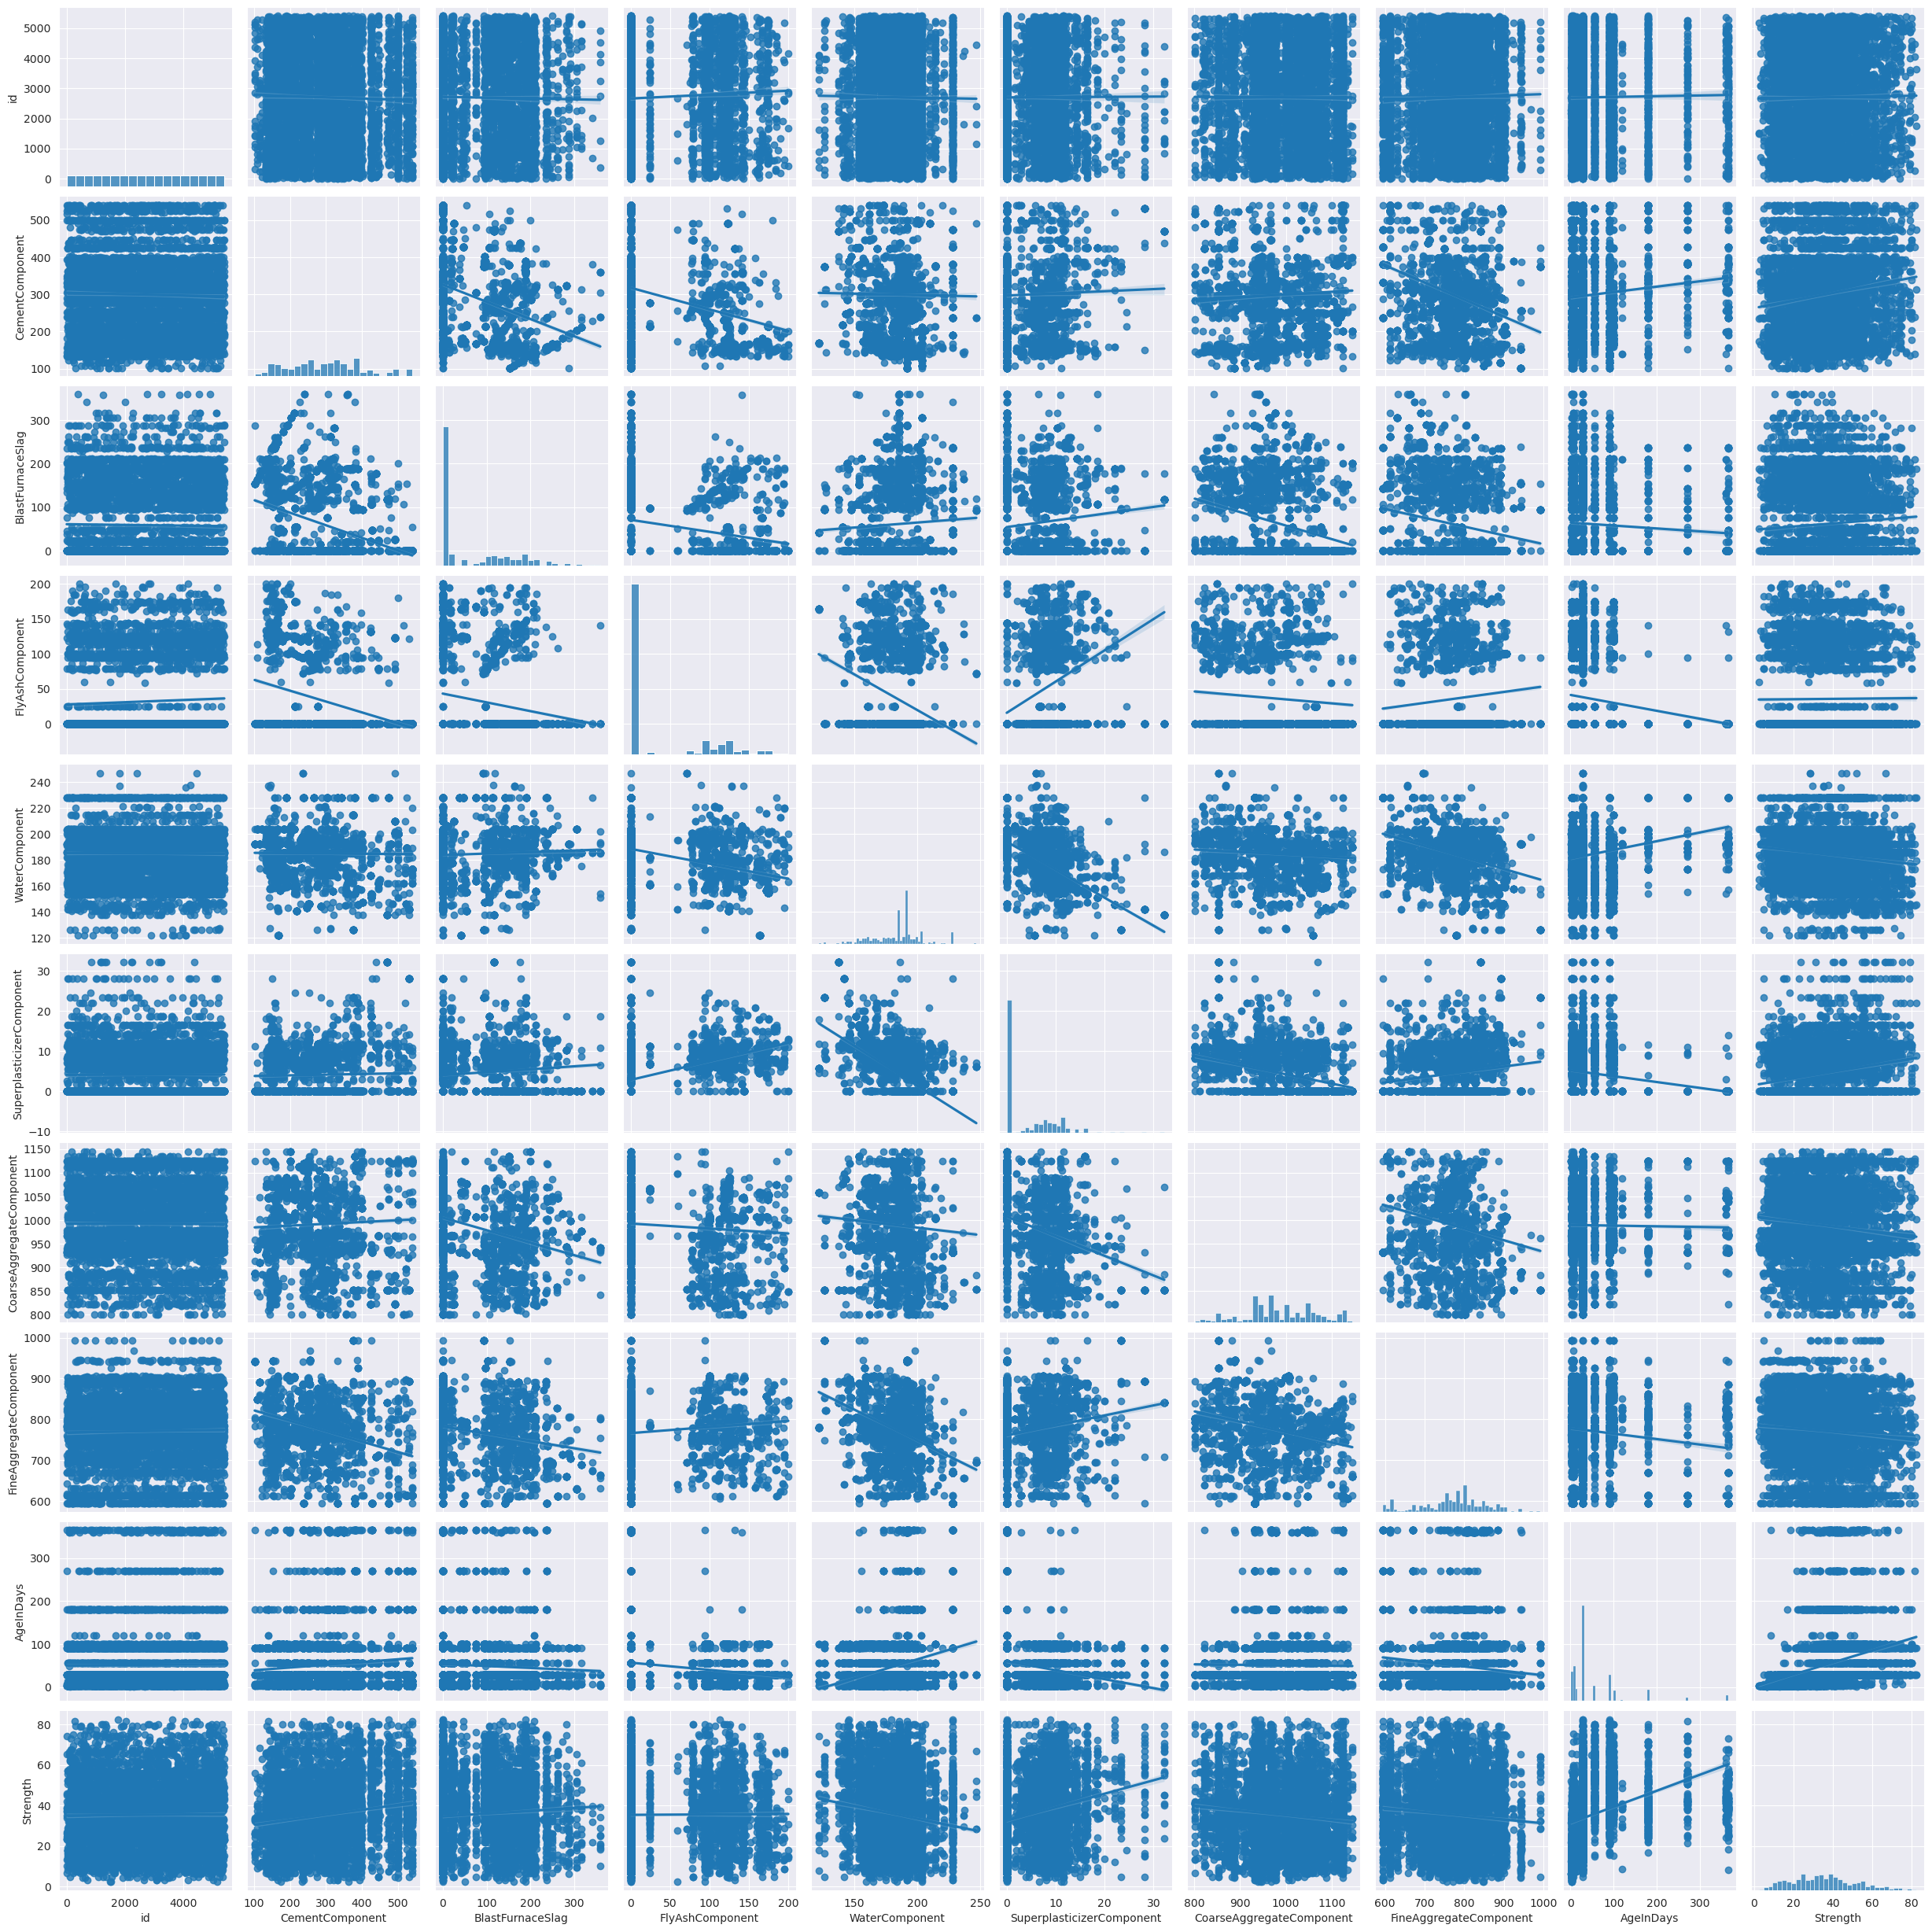

In [9]:
plt.figure(figsize=(10,8), dpi= 80)
sns.pairplot(train, kind="reg")
plt.show()

# Add Features step 1

In [10]:
def add_features(X):
    X['TotalComponentWeight'] = X['CementComponent']
    + X['BlastFurnaceSlag'] 
    + X['FlyAshComponent'] 
    + X['WaterComponent'] 
    + X['SuperplasticizerComponent'] + X['CoarseAggregateComponent'] + X['FineAggregateComponent']

    # Calculate Water-Cement-Ratio (WCR)
    X['WCR'] = X['WaterComponent'] / X['CementComponent']

    # Calculate Aggregate-Ratio (AR)
    X['AR'] = (X['CoarseAggregateComponent'] + X['FineAggregateComponent']) / X['CementComponent']

    # Calculate Water-Cement-Plus-Pozzolan-Ratio (WCPR)
    X['WCPR'] = X['WaterComponent'] / (X['CementComponent'] + X['BlastFurnaceSlag'] + X['FlyAshComponent'])

    # Calculate Cement-Age
    X['Cement-Age'] = X['CementComponent'] * X['AgeInDays']
    
    return X

In [11]:
add_features(train)
add_features(test)

,id,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,TotalComponentWeight,WCR,AR,WCPR,Cement-Age
0,5407,166.1,75.4,163.8,173.8,4.6,1007.2,746.6,56,166.1,1.046358,10.558700,0.428818,9301.6
1,5408,304.0,0.0,0.0,190.0,0.0,998.0,801.0,7,304.0,0.625000,5.917763,0.625000,2128.0
2,5409,225.0,0.0,0.0,185.0,0.0,1113.0,833.0,28,225.0,0.822222,8.648889,0.822222,6300.0
3,5410,251.4,0.0,118.3,188.5,6.4,1028.4,757.7,100,251.4,0.749801,7.104614,0.509873,25140.0
4,5411,144.0,15.0,195.0,176.0,6.0,1021.0,709.0,28,144.0,1.222222,12.013889,0.497175,4032.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3600,9007,140.0,129.0,100.0,200.0,7.0,864.0,753.0,28,140.0,1.428571,11.550000,0.542005,3920.0
3601,9008,281.0,0.0,0.0,186.0,0.0,1104.0,774.0,28,281.0,0.661922,6.683274,0.661922,7868.0
3602,9009,289.0,133.0,0.0,194.0,7.0,924.0,760.0,28,289.0,0.671280,5.826990,0.459716,8092.0
3603,9010,469.0,117.2,0.0,137.8,32.2,852.1,840.5,3,469.0,0.293817,3.608955,0.235073,1407.0


In [12]:
def feature_extraction(X):
        X[['BlastSlugT','BlastSlugF','FlyAshT','FlyAshF','SuperplasticizerT','SuperplasticizerF']]=0
        X.loc[X['BlastFurnaceSlag']  <= 0.0, ['BlastSlugT']] = 1
        X.loc[X['BlastFurnaceSlag']  > 0.0, ['BlastSlugF']] = 1
        X.loc[X['FlyAshComponent']  <= 0.0, ['FlyAshT']] = 1
        X.loc[X['FlyAshComponent']  > 0.0, ['FlyAshF']] = 1
        X.loc[X['SuperplasticizerComponent']  <= 0.0, ['SuperplasticizerT']] = 1
        X.loc[X['SuperplasticizerComponent']  > 0.0, ['SuperplasticizerF']] = 1
        
        return X

In [13]:
feature_extraction(train)
feature_extraction(test)

,id,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,TotalComponentWeight,WCR,AR,WCPR,Cement-Age,BlastSlugT,BlastSlugF,FlyAshT,FlyAshF,SuperplasticizerT,SuperplasticizerF
0,5407,166.1,75.4,163.8,173.8,4.6,1007.2,746.6,56,166.1,1.046358,10.558700,0.428818,9301.6,0,1,0,1,0,1
1,5408,304.0,0.0,0.0,190.0,0.0,998.0,801.0,7,304.0,0.625000,5.917763,0.625000,2128.0,1,0,1,0,1,0
2,5409,225.0,0.0,0.0,185.0,0.0,1113.0,833.0,28,225.0,0.822222,8.648889,0.822222,6300.0,1,0,1,0,1,0
3,5410,251.4,0.0,118.3,188.5,6.4,1028.4,757.7,100,251.4,0.749801,7.104614,0.509873,25140.0,1,0,0,1,0,1
4,5411,144.0,15.0,195.0,176.0,6.0,1021.0,709.0,28,144.0,1.222222,12.013889,0.497175,4032.0,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3600,9007,140.0,129.0,100.0,200.0,7.0,864.0,753.0,28,140.0,1.428571,11.550000,0.542005,3920.0,0,1,0,1,0,1
3601,9008,281.0,0.0,0.0,186.0,0.0,1104.0,774.0,28,281.0,0.661922,6.683274,0.661922,7868.0,1,0,1,0,1,0
3602,9009,289.0,133.0,0.0,194.0,7.0,924.0,760.0,28,289.0,0.671280,5.826990,0.459716,8092.0,0,1,1,0,0,1
3603,9010,469.0,117.2,0.0,137.8,32.2,852.1,840.5,3,469.0,0.293817,3.608955,0.235073,1407.0,0,1,1,0,0,1


**Drop NAN**

In [14]:
train = train.fillna(0)
test = test.fillna(0)

**Drop Id**

In [15]:
train = train.drop(columns = ['id'])
test = test.drop(columns = ['id'])

**Drop quantile**

In [16]:
train.columns

Index(['CementComponent', 'BlastFurnaceSlag', 'FlyAshComponent',
       'WaterComponent', 'SuperplasticizerComponent',
       'CoarseAggregateComponent', 'FineAggregateComponent', 'AgeInDays',
       'Strength', 'TotalComponentWeight', 'WCR', 'AR', 'WCPR', 'Cement-Age',
       'BlastSlugT', 'BlastSlugF', 'FlyAshT', 'FlyAshF', 'SuperplasticizerT',
       'SuperplasticizerF'],
      dtype='object')

In [17]:
def outlier_removal(data , i):
    q1 = np.quantile(data[i] ,0.25)
    q3 = np.quantile(data[i] , 0.75)
    iqr = q3-q1
    lower_tail = q1 - 1.5*iqr
    upper_tail = q3 + 1.5*iqr
    data.drop(data[data[i]> upper_tail].index , inplace = True)
    data.drop(data[data[i]< lower_tail].index ,inplace =True)
    
outlier_list = ['CementComponent', 'BlastFurnaceSlag', 'FlyAshComponent',
       'WaterComponent', 'SuperplasticizerComponent',
       'CoarseAggregateComponent', 'FineAggregateComponent', 'AgeInDays',
       'Strength', 'TotalComponentWeight', 'WCR', 'AR', 'WCPR', 'Cement-Age']
for  i in outlier_list:
    outlier_removal(train ,i)

# Data marking

In [18]:
target_col = 'Strength'
X_train = train.drop(['Strength'],axis=1).reset_index(drop=True)
y_train = train['Strength'].reset_index(drop=True)
X_test = test.reset_index(drop=True)

print(f"X_train shape :{X_train.shape} , y_train shape :{y_train.shape}")
print(f"X_test shape :{X_test.shape}")

X_train shape :(4485, 19) , y_train shape :(4485,)
X_test shape :(3605, 19)


# Add Features step 2

**https://sklearn-template.readthedocs.io/en/latest/user_guide.html**

In [19]:
class AggFeatureExtractor(BaseEstimator, TransformerMixin):
    
    def __init__(self, group_col, agg_col, agg_func):
        self.group_col = group_col
        self.group_col_name = ''
        for col in group_col:
            self.group_col_name += col
        self.agg_col = agg_col
        self.agg_func = agg_func
        self.agg_df = None
        self.medians = None
        
    def fit(self, X, y=None):
        group_col = self.group_col
        agg_col = self.agg_col
        agg_func = self.agg_func
        
        self.agg_df = X.groupby(group_col)[agg_col].agg(agg_func)
        self.agg_df.columns = [f'{self.group_col_name}_{agg}_{_agg_col}' for _agg_col in agg_col for agg in agg_func]
        self.medians = X[agg_col].median()
        
        return self
    
    def transform(self, X):
        group_col = self.group_col
        agg_col = self.agg_col
        agg_func = self.agg_func
        agg_df = self.agg_df
        medians = self.medians
        
        X_merged = pd.merge(X, agg_df, left_on=group_col, right_index=True, how='left')
        X_merged.fillna(medians, inplace=True)
        X_agg = X_merged.loc[:, [f'{self.group_col_name}_{agg}_{_agg_col}' for _agg_col in agg_col for agg in agg_func]]
        
        return X_agg
    
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        X_agg = self.transform(X)
        return X_agg

# Class Preprocessor

**https://medium.com/@Stan_DS/09-build-a-preprocessing-class-and-integrated-in-pipeline-from-scratch-14de56800866**

In [20]:
class Preprocessor:
    def __init__(self, agg_col, agg_func, group_cols):
        self.agg_col = agg_col
        self.agg_func = agg_func
        self.group_cols = group_cols
        
    def preprocess(self, X_train, X_test):        
        agg_train, agg_test = [], []
        for group_col in self.group_cols:
            agg_extractor = AggFeatureExtractor(group_col=group_col, agg_col=self.agg_col, agg_func=self.agg_func)
            agg_extractor.fit(pd.concat([X_train, X_test], axis=0))
            agg_train.append(agg_extractor.transform(X_train))
            agg_test.append(agg_extractor.transform(X_test))
        X_train = pd.concat([X_train] + agg_train, axis=1)
        X_test = pd.concat([X_test] + agg_test, axis=1)
        
        X_train = X_train.fillna(0)
        X_test = X_test.fillna(0)
        
        pca = PCA(n_components=3)
        principalComponents_train = pca.fit_transform(X_train)
        principalDf_train = pd.DataFrame(data = principalComponents_train, 
                                         columns = ['principal component 1',
                                                    'principal component 2',
                                                    'principal component 3'])
        principalComponents_test = pca.fit_transform(X_test)
        principalDf_test = pd.DataFrame(data = principalComponents_test, 
                                        columns = ['principal component 1',
                                                   'principal component 2',
                                                   'principal component 3'])
        X_train = pd.concat([X_train, principalDf_train], axis=1)
        X_test = pd.concat([X_test, principalDf_test], axis=1)
        
        return X_train, X_test

In [21]:
agg_col = ['CementComponent', 'BlastFurnaceSlag', 'FlyAshComponent','WaterComponent', 'SuperplasticizerComponent',
           'CoarseAggregateComponent', 'FineAggregateComponent', 'AgeInDays', 'TotalComponentWeight', 'WCR', 'AR', 
           'WCPR', 'Cement-Age']
agg_func = ['mean', 'std']
group_cols = [['CementComponent'], ['WaterComponent'], ['CoarseAggregateComponent'], 
              ['CementComponent', 'WaterComponent'], ['CementComponent', 'CoarseAggregateComponent'], 
              ['WaterComponent', 'CoarseAggregateComponent'], ['CementComponent', 'WaterComponent', 'CoarseAggregateComponent']]

pp = Preprocessor(agg_col, agg_func, group_cols)
X_train, X_test = pp.preprocess(X_train, X_test)

print(f"X_train shape :{X_train.shape} , y_train shape :{y_train.shape}")
print(f"X_test shape :{X_test.shape}")

X_train shape :(4485, 204) , y_train shape :(4485,)
X_test shape :(3605, 204)


# Split data

In [22]:
class Split:
    def __init__(self, test_size=0.2, kfold=True, n_splits=3):
        self.test_size = test_size
        self.kfold = kfold
        self.n_splits = n_splits

    def split_data(self, X, y, random_state_list):
        if self.kfold:
            for random_state in random_state_list:
                kf = KFold(n_splits=self.n_splits, random_state=random_state, shuffle=True)
                for train_index, val_index in kf.split(X, y):
                    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
                    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
                    yield X_train, X_val, y_train, y_val
        else:
            for random_state in random_state_list:
                X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=self.test_size, random_state=random_state)
                yield X_train, X_val, y_train, y_val

kfold = True
n_splits = 5
random_state = 2000
random_state_list = [42, 71, 25] # split_data

splitter = Split(kfold=kfold, n_splits=n_splits)

In [23]:
n_estimators = 9999
device = "cpu"

xgb_params = {
    'n_estimators': n_estimators,
    'learning_rate': 0.05,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:squarederror'
}

lgb_params = {
    'n_estimators': n_estimators,
    'learning_rate': 0.05,
    'max_depth': 10,
    'subsample_for_bin': 20000,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'regression',
    'device': device
}

cb_params = {
    'n_estimators': n_estimators,
    'learning_rate': 0.1,
    'max_depth': 6,
    'loss_function': 'RMSE',
    'verbose': False,
    'task_type': device.upper()
}

In [24]:
def train_regressor(regressor, X_train, y_train, X_val, y_val, regressor_params, early_stopping_rounds=100, random_state=42):
    regressor = regressor(**regressor_params, random_state=random_state)
    eval_set = [(X_val, y_val)]
    regressor.fit(X_train, y_train, early_stopping_rounds=early_stopping_rounds, eval_set=eval_set, verbose=False)
    val_preds = regressor.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, val_preds))
    return regressor, rmse

In [25]:
xgb_models, lgb_models, cb_models = [], [], []
xgb_scores, lgb_scores, cb_scores = [], [], []
for X_train_, X_val, y_train_, y_val in splitter.split_data(X_train, y_train, random_state_list=random_state_list):
    xgb_model, xgb_rmse = train_regressor(xgb.XGBRegressor, X_train_, y_train_, X_val, y_val, xgb_params)
    lgb_model, lgb_rmse = train_regressor(lgb.LGBMRegressor, X_train_, y_train_, X_val, y_val, lgb_params)
    cb_model, cb_rmse = train_regressor(CatBoostRegressor, X_train_, y_train_, X_val, y_val, cb_params)
    xgb_models.append(deepcopy(xgb_model)), lgb_models.append(deepcopy(lgb_model)), cb_models.append(deepcopy(cb_model))
    xgb_scores.append(xgb_rmse), lgb_scores.append(lgb_rmse), cb_scores.append(cb_rmse)

# OptunaWeights

**https://optuna.readthedocs.io/en/stable/reference/generated/optuna.integration.WeightsAndBiasesCallback.html**

In [26]:
class OptunaWeights:
    def __init__(self, random_state):
        self.study = None
        self.weights = None
        self.random_state = random_state

    def _objective(self, trial, y_true, y_preds):
        # Define the weights for the predictions from each model
        weights = [trial.suggest_float(f"weight{n}", 0, 1) for n in range(len(y_preds))]

        # Calculate the weighted prediction
        weighted_pred = np.average(np.array(y_preds).T, axis=1, weights=weights)

        # Calculate the ROC AUC score for the weighted prediction
        score = np.sqrt(mean_squared_error(y_true, weighted_pred))
        return score

    def fit(self, y_true, y_preds, n_trials=300):
        optuna.logging.set_verbosity(optuna.logging.ERROR)
        sampler = optuna.samplers.CmaEsSampler(seed=self.random_state)
        self.study = optuna.create_study(sampler=sampler, study_name="OptunaWeights", direction='minimize')
        objective_partial = partial(self._objective, y_true=y_true, y_preds=y_preds)
        self.study.optimize(objective_partial, n_trials=n_trials)
        self.weights = [self.study.best_params[f"weight{n}"] for n in range(len(y_preds))]

    def predict(self, y_preds):
        assert self.weights is not None, 'OptunaWeights error, must be fitted before predict'
        weighted_pred = np.average(np.array(y_preds).T, axis=1, weights=self.weights)
        return weighted_pred

    def fit_predict(self, y_true, y_preds, n_trials=300):
        self.fit(y_true, y_preds, n_trials=n_trials)
        return self.predict(y_preds)
    
    def weights(self):
        return self.weights

In [27]:
models = np.array([xgb_models, lgb_models, cb_models]).T.tolist()
names = ['XGBoost', 'LightGBM', 'CatBoost']

# Initialize variables
test_predss = np.zeros(X_test.shape[0])
ensemble_score = []
weights = []

# Loop through the folds
i = 0
for _model, (X_train_, X_val, y_train_, y_val) in zip(models, splitter.split_data(X_train, y_train, random_state_list=random_state_list)):
    n = i % n_splits
    m = i // n_splits
    val_preds, test_preds, zero_test_preds = [], [], []
    for model in _model:
        oof_pred = model.predict(X_val.values)
        test_pred = model.predict(X_test.values)
        val_preds.append(oof_pred)
        test_preds.append(test_pred)
        
    # Use Optuna to find the best ensemble weights
    optweights = OptunaWeights(random_state=random_state)
    val_pred = optweights.fit_predict(y_val.values, val_preds)
    score = np.sqrt(mean_squared_error(y_val, val_pred))
    print(f'[FOLD-{n} SEED-{random_state_list[m]}] RMSE score {score:.5f}')
    ensemble_score.append(score)
    weights.append(optweights.weights)
    
    # Predict on the test set using the optimized ensemble weights
    test_predss += optweights.predict(test_preds) / (n_splits * len(random_state_list))
    i += 1
    
# Calculate the mean AUC score of the ensemble
mean_score = np.mean(ensemble_score)
std_score = np.std(ensemble_score)
print(f'Ensemble RMSE score {mean_score:.5f} ± {std_score:.5f}')

# Print the mean and standard deviation of the ensemble weights for each model
print('--- Model Weights ---')
mean_weights = np.mean(weights, axis=0)
std_weights = np.std(weights, axis=0)
for name, mean_weight, std_weight in zip(names, mean_weights, std_weights):
    print(f'{name} {mean_weight:.5f} ± {std_weight:.5f}')

[FOLD-0 SEED-42] RMSE score 11.11108
[FOLD-1 SEED-42] RMSE score 10.89651
[FOLD-2 SEED-42] RMSE score 11.32689
[FOLD-3 SEED-42] RMSE score 11.39444
[FOLD-4 SEED-42] RMSE score 11.31989
[FOLD-0 SEED-71] RMSE score 11.38791
[FOLD-1 SEED-71] RMSE score 11.30012
[FOLD-2 SEED-71] RMSE score 11.46927
[FOLD-3 SEED-71] RMSE score 11.02881
[FOLD-4 SEED-71] RMSE score 11.14348
[FOLD-0 SEED-25] RMSE score 11.29747
[FOLD-1 SEED-25] RMSE score 10.89706
[FOLD-2 SEED-25] RMSE score 11.76116
[FOLD-3 SEED-25] RMSE score 11.03911
[FOLD-4 SEED-25] RMSE score 11.35646
Ensemble RMSE score 11.24864 ± 0.22356
--- Model Weights ---
XGBoost 0.20488 ± 0.26704
LightGBM 0.38224 ± 0.27740
CatBoost 0.81845 ± 0.13857


In [28]:
sub = pd.read_csv('/kaggle/input/playground-series-s3e9/sample_submission.csv')
sub['Strength'] = test_predss
sub

,id,Strength
0,5407,45.790523
1,5408,22.244829
2,5409,31.798391
3,5410,45.054370
4,5411,27.830743
...,...,...
3600,9007,33.997223
3601,9008,34.580174
3602,9009,36.263200
3603,9010,30.793625


In [29]:
sub.to_csv('submission.csv', index=False)